In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
import random
import seaborn as sns
import skbio.diversity.alpha as alpha
#import skbio.math.diversity.alpha

/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Importing OTU table, normalization (change to relative abundances), set training and testing groups

In [3]:
# Import data into a pandas dataframe
otu_table = pd.read_csv('EGAD00001003453.otu_table.99.denovo', sep='\t', header=0, index_col=0)

#Transpose OTU table so that samples are rows and OTUs are columns
otu_table = otu_table.T

#Convert to relative abundances
#Normalize each person to 1 (change to relative abundances)
otu_table_normalized = otu_table.div(otu_table.sum(axis=1), axis=0)

In [4]:
#Make training and testing sets (50/50 for now)

#Scramble existing table with hard-coded random seed
otu_table_normalized = otu_table_normalized.sample(frac=1, random_state=1)

#Make first half training and second half testing
total_people = otu_table_normalized.shape[0]
print(total_people)
midway = total_people/2
training_table = otu_table_normalized.iloc[0:int(midway)]
testing_table = otu_table_normalized.iloc[int(midway):]


1010


### Set conditions to test:

In [5]:
N = [5, 10, 50, 100, 250]
weight_setup = ['even', 'uneven_100x', 'uneven_10x', 'uneven_graduated']#, 'uneven_bins']
num_bins = 3

#Number of times to run each condition (N and weight setup)
num_repeats = 5

### Functions

In [6]:
def calculate_weights(n,weight):
    if weight == 'even':
        return [1/n]*n
    elif weight == 'uneven_100x':
        x = 1/(100 + (n-1))
        return [100*x] + [x]*(n-1)
    elif weight == 'uneven_10x':
        x = 1/(10 + (n-1))
        return [10*x] + [x]*(n-1)
    elif weight == 'uneven_graduated':
        decreasing_list = list(range(n,0,-1))
        return [x/sum(decreasing_list) for x in decreasing_list]
    #elif weight == 'uneven_bins':
        #n/

    

### Master loop

In [7]:
df_list = []
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = training_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
final_matrix = pd.concat(df_list, axis=1)
print(final_matrix.tail())

                                       0  \
OTU_ID                                     
sample_name                     5_even_0   
N                                      5   
weight_setup                        even   
weight_vector  [0.2, 0.2, 0.2, 0.2, 0.2]   
random_seed                        15075   

                                                               1  \
OTU_ID                                                             
sample_name                                      5_uneven_100x_0   
N                                                              5   
weight_setup                                         uneven_100x   
weight_vector  [0.9615384615384616, 0.009615384615384616, 0.0...   
random_seed                                                15075   

                                                               2  \
OTU_ID                                                             
sample_name                                       5_uneven_10x_0   
N         

In [8]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
final_matrix = final_matrix.T

In [9]:
final_matrix.to_csv('final_matrix.csv')

In [23]:
otu_table_normalized.max().sort_values(ascending=False)

OTU_ID
denovo2        0.618619
denovo4        0.507051
denovo31       0.452548
denovo1        0.399068
denovo20       0.289688
denovo25       0.258867
denovo11       0.256528
denovo5        0.226640
denovo528      0.222675
denovo22       0.213988
denovo28       0.212926
denovo3        0.188978
denovo62       0.187109
denovo8        0.186591
denovo18       0.183463
denovo15       0.183285
denovo21       0.176677
denovo7        0.176353
denovo154      0.173165
denovo16       0.166897
denovo6        0.166038
denovo109      0.163039
denovo9        0.161565
denovo80       0.151196
denovo37       0.147789
denovo23       0.146666
denovo24       0.146600
denovo117      0.143706
denovo14       0.143110
denovo13       0.138829
                 ...   
denovo29274    0.000016
denovo43686    0.000016
denovo43256    0.000016
denovo39166    0.000016
denovo45026    0.000016
denovo44301    0.000016
denovo45019    0.000016
denovo45144    0.000015
denovo45499    0.000015
denovo38688    0.000015
denovo437

In [18]:
final_matrix.iloc[:, :-5].max().sort_values(ascending=False)

OTU_ID
denovo1        0.019320
denovo2        0.011697
denovo4        0.009618
denovo28       0.009470
denovo14       0.009339
denovo25       0.008913
denovo9        0.008508
denovo7        0.007982
denovo17       0.007827
denovo6        0.007620
denovo11       0.007356
denovo5        0.007049
denovo3        0.006571
denovo23       0.006225
denovo20       0.005869
denovo19       0.005725
denovo13       0.005668
denovo8        0.005351
denovo31       0.005157
denovo16       0.005068
denovo10       0.004886
denovo82       0.004439
denovo18       0.004364
denovo21       0.004300
denovo193      0.003669
denovo15       0.003558
denovo12       0.003538
denovo37       0.003206
denovo26       0.002936
denovo62       0.002737
                 ...   
denovo44312    0.000000
denovo38360    0.000000
denovo41220    0.000000
denovo35027    0.000000
denovo30773    0.000000
denovo9232     0.000000
denovo22412    0.000000
denovo4792     0.000000
denovo45411    0.000000
denovo39200    0.000000
denovo242

In [10]:
final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22219,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed
0,0,0,0,0,0,0,0,0,0,0,...,4.02149e-06,0,0,0,0,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]",15075
1,0,0,0,0,0,0,0,0,0,0,...,3.86682e-08,0,0,0,0,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...",15075
2,0,0,0,0,0,0,0,0,0,0,...,2.76201e-09,0,0,0,0,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...",15075
3,0,0,0,0,0,0,0,0,0,0,...,2.29644e-10,0,0,0,0,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...",15075
4,3.03548e-07,1.01183e-07,0,0,0,0,0,0,0,0,...,0,1.01183e-07,1.29338e-07,0,1.01183e-07,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",21745
5,2.78485e-09,9.28283e-10,0,0,0,0,0,0,0,0,...,0,9.28283e-10,1.18658e-09,0,9.28283e-10,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...",21745
6,1.46571e-10,4.8857e-11,0,0,0,0,0,0,0,0,...,0,4.8857e-11,6.24518e-11,0,4.8857e-11,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...",21745
7,2.39843e-11,7.99478e-12,0,0,0,0,0,0,0,0,...,0,7.99478e-12,9.0839e-12,0,7.99478e-12,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...",21745
8,1.42558e-08,5.73782e-08,0,0,0,4.38553e-09,5.72312e-09,0,6.99583e-09,0,...,4.04617e-09,4.04617e-09,0,1.33654e-08,0,50_even_0,50,even,"[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.0...",28100
9,9.56768e-11,5.09527e-09,0,0,0,2.94331e-11,3.84102e-11,0,4.69519e-11,0,...,2.71555e-11,2.71555e-11,0,8.97007e-11,0,50_uneven_100x_0,50,uneven_100x,"[0.6711409395973155, 0.006711409395973154, 0.0...",28100


In [1]:
# for index, row in final_matrix.iterrows():
#     row['n_otus'] = row[:row.size-6].astype(bool).sum()
#     if row['weight_setup'] == 'even':
#         set_up_coordinates(row, even_x, even_y)
#     elif row['weight_setup'] == 'uneven_100x':
#         set_up_coordinates(row, uneven_100x_x, uneven_100x_y)
#     elif row['weight_setup'] == 'uneven_10x':
#         set_up_coordinates(row, uneven_10x_x, uneven_10x_y)
#     elif row['weight_setup'] == 'uneven_graduated':
#         set_up_coordinates(row, uneven_graduated_x, uneven_graduated_y)

final_matrix['n_otus'] = final_matrix[:final_matrix.shape[0]-5].astype(bool).sum(axis=1).astype(int)



#print(row[:len(row)-6] for index, row in final_matrix.iterrows())
#for index, row in final_matrix.iterrows():
#    print(list(row[:len(row)-6]))
#relabundance_list_float = [list(row[:len(row)-6])*20000 for index, row in final_matrix.iterrows()]
#final_matrix['ace'] = [alpha.ace([int(item) for item in relabundance_list_float])]





NameError: name 'final_matrix' is not defined

In [29]:
final_matrix_otus_only = final_matrix.iloc[:,:-6]*1000000
print(final_matrix_otus_only.astype(int))

OTU_ID  denovo7709  denovo5395  denovo11322  denovo44859  denovo44858  \
0                0           0            0            0            0   
1                0           0            0            0            0   
2                0           0            0            0            0   
3                0           0            0            0            0   
4                0           0            0            0            0   
5                0           0            0            0            0   
6                0           0            0            0            0   
7                0           0            0            0            0   
8                0           0            0            0            0   
9                0           0            0            0            0   
10               0           0            0            0            0   
11               0           0            0            0            0   
12               0           0            0        

In [ ]:
final_matrix['ace'] = [alpha.ace(list(row for index, rows in final_matrix_otus_only.iterrows()))]

In [13]:
# print(uneven_100x_y)
# print(even_y)

In [14]:
# plt.subplot(2,2,1)
# plt.plot(even_x, even_y)
# plt.subplot(2,2,2)
# plt.plot(uneven_100x_x,uneven_100x_y)
# plt.subplot(2,2,3)
# plt.plot(uneven_10x_x,uneven_10x_y)
# plt.subplot(2,2,4)
# plt.plot(uneven_graduated_x, uneven_graduated_y)
# plt.show()

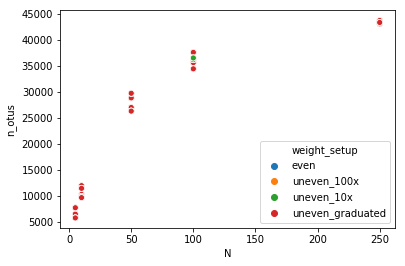

In [15]:
sns.scatterplot(x='N',y='n_otus',hue='weight_setup',data=final_matrix)
plt.show()

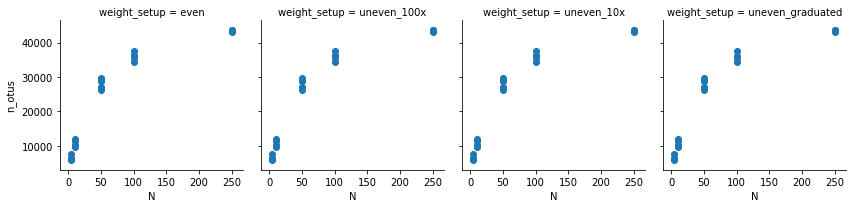

In [16]:
g = sns.FacetGrid(col='weight_setup', data=final_matrix)
g.map(plt.scatter, 'N', 'n_otus')
plt.show()

In [17]:
counts

NameError: name 'counts' is not defined